In [1]:
# Colab setup
import os
import torch
import lightning

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


torch.manual_seed(41)

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sA/COLVAR",
              "https://raw.githubusercontent.com/luigibonati/masterclass-plumed/main/1_DeepLDA/0_unbiased-sB/COLVAR" ]
n_states = len(filenames)

dataset, df = create_dataset_from_files(
	filenames,
	filter_args={'regex':'d_' }, # select distances between heavy atoms
	create_labels=True,
	return_dataframe=True,
)

Class 0 dataframe shape:  (5001, 53)
Class 1 dataframe shape:  (5001, 53)

 - Loaded dataframe (10002, 53): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'walker', 'labels']
 - Descriptors (10002, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15

# Analysis of MLCV

## Load model

In [3]:
from mlcolvar.cvs import DeepTDA

# Parameters
n_cvs = 1
target_centers = [-7, 7]
target_sigmas = [0.2, 0.2]
nn_layers = [45, 24, 12, 1]

# Initialize DeepTDA model
model = DeepTDA(
    n_states=n_states,
    n_cvs=n_cvs,
    target_centers=target_centers,
    target_sigmas=target_sigmas,
    layers=nn_layers
)

model

DeepTDA(
  (loss_fn): TDALoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=24, out_features=12, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=12, out_features=1, bias=True)
    )
  )
)

In [4]:
checkpoint_file = torch.load('./deeptda-v1.pt')
model.load_state_dict(checkpoint_file)
model.eval()

DeepTDA(
  (loss_fn): TDALoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=24, out_features=12, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=12, out_features=1, bias=True)
    )
  )
)

## Visualize

In [5]:
X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

n_components = n_states-1

for i in range(n_components):
    df[f'CV{i}'] = -1 * s[:,i]

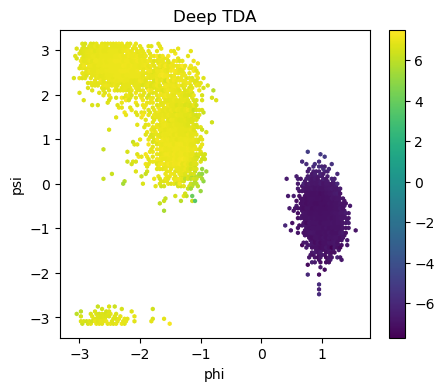

In [13]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax,)
    ax.set_title(f'Deep TDA')

# More data points

In [7]:
more_data = torch.load("../../../data/alanine/heavy_atom_distance.pt")
more_data.shape

torch.Size([1000000, 45])

In [8]:
n_components = 1
with torch.no_grad():
    s = -1 * model(more_data).numpy()
    
new_df = pd.DataFrame(s, columns=[f'CV{i}' for i in range(n_components)])
new_df

,CV0
0,7.070565
1,7.072603
2,7.075931
3,7.080373
4,7.105026
...,...
999995,6.399127
999996,7.011268
999997,5.449573
999998,7.154682


In [9]:
psis = np.load("../../../data/alanine/heavy_atom_distance_psis.npy")
phis = np.load("../../../data/alanine/heavy_atom_distance_phis.npy")
new_df['psi'] = psis
new_df['phi'] = phis
new_df

,CV0,psi,phi
0,7.070565,2.724753,-2.496995
1,7.072603,2.714459,-2.490017
2,7.075931,2.701140,-2.479672
3,7.080373,2.702199,-2.466322
4,7.105026,2.717623,-2.420580
...,...,...,...
999995,6.399127,2.619246,-1.407471
999996,7.011268,2.730429,-1.359652
999997,5.449573,2.644886,-1.330804
999998,7.154682,2.551387,-1.297497


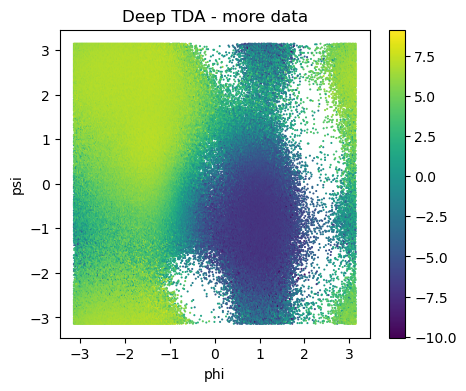

In [14]:
n_components = 1

fig,axs = plt.subplots(1, n_components, figsize = ( 5 * n_components, 4) )
if n_components == 1:
    axs = [axs]

for i,ax in enumerate(axs):
    new_df.plot.hexbin('phi','psi',C=f'CV{i}',cmap='viridis',ax=ax, gridsize=400)
    ax.set_title(f'Deep TDA - more data')

In [11]:
max_cv0 = new_df['CV0'].max()
min_cv0 = new_df['CV0'].min()
boundary = np.linspace(min_cv0, max_cv0, 10)
boundary

array([-11.64144135,  -9.10495345,  -6.56846555,  -4.03197765,
        -1.49548976,   1.04099814,   3.57748604,   6.11397394,
         8.65046183,  11.18694973])

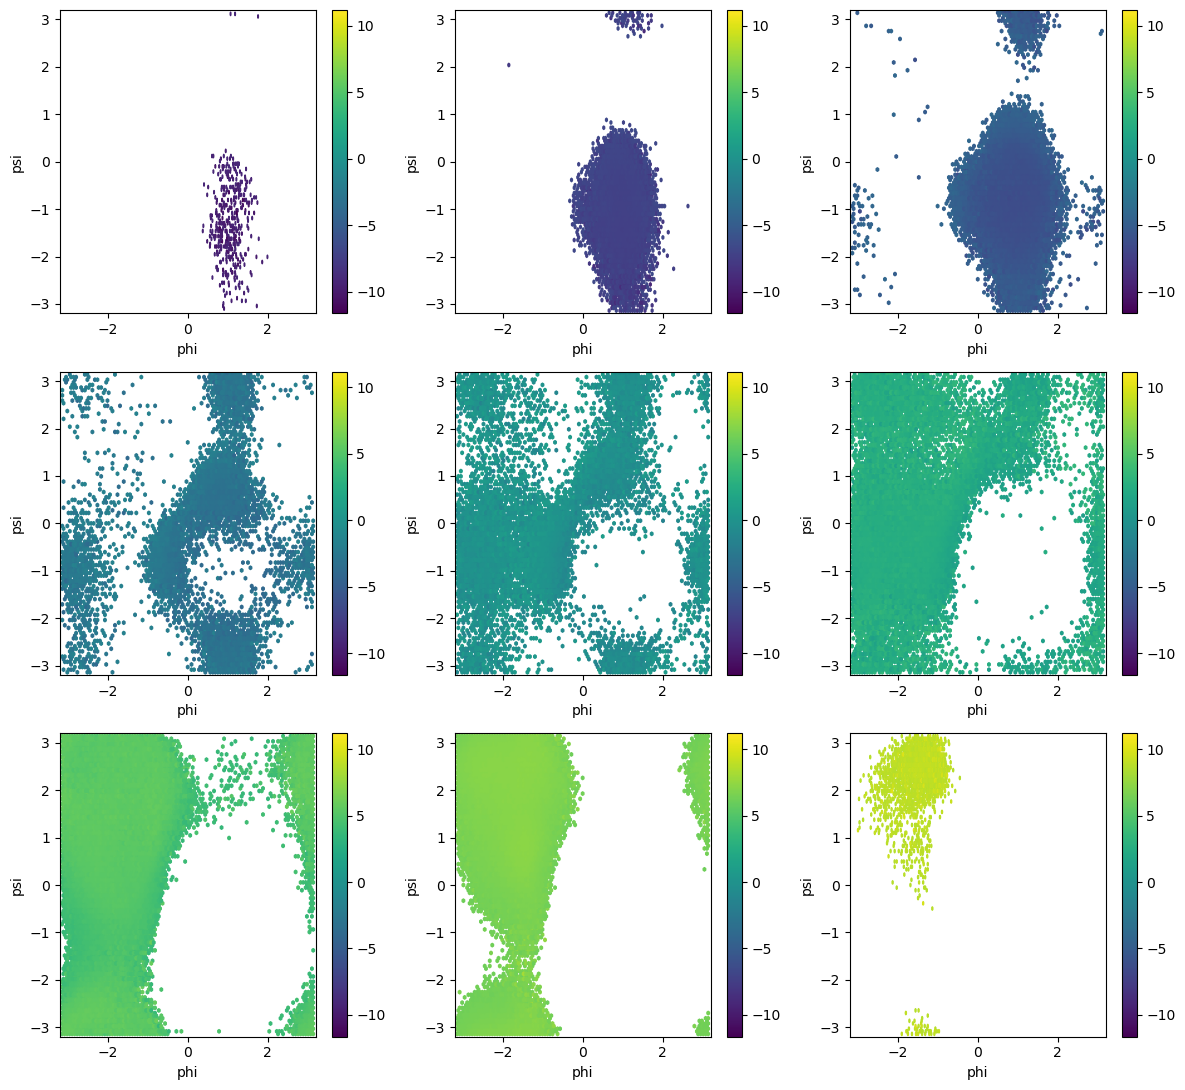

In [12]:
fig,axs = plt.subplots(3, 3, figsize = ( 12, 11 ) )
axs = axs.ravel()
hexbin_instance = None

for i in range(0, min(len(boundary)-1, 9)):
	ax = axs[i]
	df_selected = new_df[(new_df[f'CV0'] <= boundary[i+1]) & (new_df[f'CV0'] >= boundary[i])]
	if len(df_selected) == 0:
		continue
	hexbin_instance = df_selected.plot.hexbin(
		'phi', 'psi', C=f'CV0',
  		vmin=boundary[0], vmax=boundary[-1],
    	cmap='viridis', ax=ax
    )
	# ax.set_title(f'CV value in [{boundary[i]:.2f},{boundary[i+1]:.2f}]')
	ax.set_xlim(-3.2, 3.2)
	ax.set_ylim(-3.2, 3.2)

plt.tight_layout()